In this notebook, I'm going to go through the same dataset in the `data_exploration` and `tfidf` notebooks, but use FastAI's NLP libraries to try to build a classifier for fake vs real with a neural net model

In [1]:
from fastai.text.all import get_text_files, Path, TextDataLoaders, language_model_learner, text_classifier_learner, accuracy, Perplexity, AWD_LSTM, AWD_QRNN
import pandas as pd

In [2]:
path = Path("/home/g-clef/turbo_stuff/fake_news_analysis/data/")

So we need to make a "DataLoader" in fastai terminology, which is an object that loads the data from disk and prepares it for feeding to the learning model in batches. The dataloader for text also handles a bunch of lexical parsing, stemming, punctuation handling, etc.

This next step raises a numpy warning every time, and does in the fastai documentation as well, so I'm going to ignore that for the moment.

In earlier uses of this, I was experimenting with lowering the batch size (`bs=4`) and block size `block_size=4`. That was mostly related to tryign to get a languate learner to work and fit in RAM. For the text classifier that mostly seemed to just slow things down and make determining a good learning rate difficult.

In [3]:
dls = TextDataLoaders.from_csv(path=path, csv_fname="news.csv", text_col=["title", "text"], label_col="label", valid_pct=0.2)

/home/g-clef/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [4]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxfld 1 xxmaj re : xxmaj why xxmaj are xxmaj so xxmaj many xxmaj people xxmaj choosing xxmaj to xxmaj leave xxmaj the xxmaj united xxmaj states xxmaj permanently ? xxfld 2 xxmaj why xxmaj are xxmaj so xxmaj many xxmaj people xxmaj choosing xxmaj to xxmaj leave xxmaj the xxmaj united xxmaj states xxmaj permanently ? xxmaj august 11th , 2013 \n xxmaj have things gotten so bad that it is time to leave the xxmaj united xxmaj states for good ? xxmaj that is a question that a lot of xxmaj americans are dealing with these days , and an increasing number of them are choosing to leave the country of their birth permanently . xxmaj some are doing it for tax reasons , some are doing it because they believe the future is brighter elsewhere , and others are doing it because they are very distressed",FAKE
1,"xxbos xxfld 1 xxmaj fascism xxmaj in xxmaj india - xxunk xxfld 2 in xxmaj communal xxmaj harmony — by xxmaj xxunk xxmaj xxunk — xxmaj november 5 , 2016 \n xxmaj on xxmaj monday the 31st of xxmaj october 2016 the xxmaj xxunk xxmaj pradesh police assassinated eight alleged associates of the xxmaj students ’ xxmaj islamic xxmaj movement of xxmaj india ( simi ) after an alleged escape from prison near xxmaj bhopal . xxmaj this was not coincidentally a day when the xxmaj prime xxmaj minister xxmaj narendra xxmaj modi was hyping xxmaj hindu nationalism on xxmaj diwali , the xxmaj hindu festival that celebrates the return of the xxunk god xxmaj ram to xxmaj xxunk in present day xxmaj xxunk xxmaj pradesh . xxmaj the assassination was most certainly a celebration of xxmaj diwali and xxmaj hindu nationalism by assassination of xxmaj muslims . xxmaj narendra",FAKE
2,"xxbos xxfld 1 xxup lucifer in the xxmaj temple of the xxmaj dog xxup ii xxfld 2 xxup isis xxmaj takes xxmaj out xxup xxunk xxmaj abrams xxmaj tank with xxmaj american xxup tow xxmaj missile ( video ) ‹ › xxmaj bio by xxmaj jack xxmaj heart : xxmaj my earliest memories were of being surrounded by machinery and a constant deep mechanical humming rose and fell like the breath of xxunk sleep . xxmaj maybe it was the "" mother ship "" or the "" montauk underground "" like xxmaj preston xxmaj nichols author of the xxmaj the xxmaj montauk xxmaj projects would later claim but i am inclined to believe it was the post natal care room at xxmaj xxunk xxmaj medical xxmaj center in xxmaj brooklyn where i was born to a well to do family . i grew up in xxmaj brooklyn . xxmaj my",FAKE


So this is a lot of pre-parsed text. There's a lot to talk about how this parsing is working. FastAI offers multiple ways to "tokenize" text. By default, a TextDataLoader will use a tokenizer called `spaCy`. FastAI mostly uses spacy to split on words in an intelligent way (don't split punctuation in the middle of a number or a price, for example, but do split `it's` into `it s`. FastAI wraps that in a class of its own, so if you look in the TextDataLoader, it will be called a "WordTokenizer", to allow them to swap that out if they find something better than spaCy. 

FastAI will go beyond spacy word splitting, to help identify special areas of the strings. FastAI will identify words and add extra tokens to indicate other information about the words it tokenizes. The tokens above that start with `xx` are special tokens added by FastAI. For example `xxbos` means "beginning of string" to mark the beginning of the set of things being tokenized, `xxmaj` means that the next word started with a capital letter, `xxunk` means the next word was unknown, etc. `xxup` means all letters were uppercase, `xxfld 1` means this data was in field 1. This is how FastAI handles the fact that data may have come from more than one field in the incoming CSV: it tags the text that's from that field with a special token at the beginning of that field's data. 

If spaces aren't useful,  you may ned to use a "subword" tokenizer. (note: the book claims that subword tokenizers can handle genomic sequences and MIDI notiation...possible to use subword tokenizers and language models with them to do file analysis? Files could be treated as just a string of hexadecimal values at that point.)

Moving on, next we make a text_classifier learner. It may be tempting to try to create a full language learner here, but in my experience the language learners required more RAM than I had available in my GPU (and I've got 8GB).

The difference between a language learner and a text classifier appears to be that a language learner learns the corpus to allow it to make predictions about later words given a starting point. So it will generate or finish sentences in the style of the corpus given a starting point. A clasifier on the other hand, will just give you a classification of which label a given text belongs in. 

In [5]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0010000000474974513)

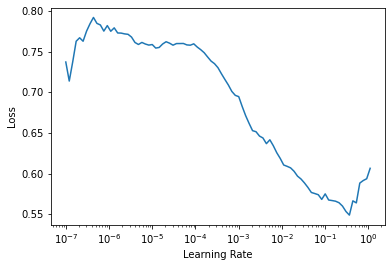

In [6]:
learn.lr_find()

This looks like a fairly typical learning rate curve from a FastAI perspective: It's semi-bathtub-shaped, with a long section with a steeply-dropping loss in the middle. That implies the techniques used by the vanilla FastAI learners will work fairly well here without much modification. Let's try just one cycle:

In [7]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.399221,0.297955,0.873717,1.347101,01:05


accuracy 87% on one round? Not bad at all. Let's try again, but train for more than one epoch. (this may take a *long* time)

In [8]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.497114,0.359929,0.856354,1.433228,01:07
1,0.395303,0.291344,0.872139,1.338225,01:06
2,0.345691,0.261555,0.889503,1.298948,01:05
3,0.315118,0.254234,0.885556,1.289473,01:05
4,0.281368,0.244851,0.888713,1.277431,01:05
5,0.258485,0.251115,0.888713,1.285458,01:07
6,0.245854,0.248446,0.889503,1.282032,01:05
7,0.241444,0.261919,0.887924,1.299422,01:05


89% accuracy. Not much change from the original, and seems to have flatlined at that accuracy.

One thing, though: the `drop_mult` is a bit of a magic number that I took from someone else's analysis. FastAI documentation says that `drop_mult` is a common weight to apply to all the kinds of dropout that the library can use. So, turning that up causes more dropout of all kinds, down causes less. Dropout is a method used to avoid overfitting data. With dropout, during training some of the activation values for the non-linear layers in the model are set to 0 for that round, to force the model to see whether simply removing that activation makes things better or worse. In the text classifier, there are actually multiple types of Dropout: at hidden, input, embed, and weight. These set the probability the learner will disable a given activation (in effect the % of activations that will be disabled in a  given batch). 

Let's see what happens if we change that value for this dataset.

In [9]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=1, metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.491514,0.459929,0.779795,1.583961,01:05


well, that's a good deal less accurate on a first run. Perhaps a bit smaller?

In [10]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.7, metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.463297,0.375833,0.819258,1.456203,01:05


82%...still worse than the original 0.3 guess. Let's try setting it smaller than 0.3.

In [11]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.2, metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.401169,0.311660,0.874507,1.365691,01:05


ooh. it's slightly better. Apparently we can't turn dropout off entirely (pytorch exceptions somewhere under the hood). Let's try setting it even lower.

In [12]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.01, metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.384740,0.294898,0.875296,1.342989,01:06


89% on one round. Not bad. Let's try multiple rounds with very little dropout.

In [13]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.01, metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.428597,0.288850,0.880821,1.334892,01:05
1,0.313833,0.257216,0.894238,1.293325,01:06
2,0.257035,0.234647,0.906077,1.264462,01:07
3,0.203199,0.233756,0.902131,1.263336,01:05


A bit of an improvement in accuracy, but seems to be plateauing. One warning, though: the `train_loss` is getting smaller than the `valid_loss`, which seems to be plateau'ing. That's a sign that we need to turn the dropout back up, since it might be memorizing our input data set. 

after reading a little more, it turns out that the fastai folks don't recommend doing multiple rounds like this. They say that better results are gained by doing a series of `fit_one_cycle(1)` calls, followed by `freeze_to(-x)` calls with increasing negative arguments.

What that does is fit the last layers in the model one by one, rather than all at once. Their example does three layers, then unfreezes the whole model and does a fit across.

Let's try that.

One thing: this ran out of RAM at the `freeze_to(-3)` stage the first time I tried it, so I think we have to re-create the dataloader for this with a smaller batch size.

In [14]:
dls = TextDataLoaders.from_csv(path=path, csv_fname="news.csv", text_col=["title", "text"], label_col="label", valid_pct=0.2, bs=8)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.2, metrics=[accuracy, Perplexity()])

/home/g-clef/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.422103,0.289651,0.883978,1.335962,03:38


In [16]:
learn.freeze_to(-2)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.369540,0.214328,0.928177,1.239029,04:24


In [17]:
learn.freeze_to(-3)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.309182,0.171190,0.931334,1.186716,05:25


In [18]:
learn.unfreeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.218524,0.099522,0.966851,1.104643,07:04
1,0.130463,0.165690,0.957380,1.180207,07:03
2,0.128321,0.328811,0.954223,1.389315,07:01
3,0.061000,0.192668,0.962115,1.212480,07:04
4,0.066970,0.154391,0.965272,1.166947,07:04


97%. Just wow. I'm a little concerned that this is over-fit, though, since the `train_loss` is smaller than the `valid_loss` (which is what the FastAI folks say to watch out for when training). Also, `valid_loss` is flatlining, and sometimes going *up*, which is another indication that it's overfit.

Before we go deeper into what it's doing, let's have a little fun & see what it does with predicting the classification of some sentences

In [19]:
starting_word = "This is a lie"
learn.predict(starting_word)

('FAKE', tensor(0), tensor([1.0000e+00, 2.9312e-06]))

In [20]:
starting = "Is is possible that the length of a string has an impact on whether it's classified as fake? Let's see. This may also trigger on the fact that there are multiple sentences here."
learn.predict(starting)

('FAKE', tensor(0), tensor([9.9908e-01, 9.2202e-04]))

In [21]:
starting = "This is a lie. This is a lie. This is a lie. This is a lie. This is a lie."
learn.predict(starting)

('FAKE', tensor(0), tensor([9.9981e-01, 1.9177e-04]))

huh. They're all fake. How do I get a real one? Let's grab an actual story from 2016 that wasn't in the original dataset & see how it classifies

In [22]:
body = """President Obama called it, "an attack of terror and an attack of hate." Omar Mateen's early June rampage, in which he gunned down 50 people in the gay nightclub near downtown Orlando, was the deadliest mass shooting in United States history. His comments and perceived allegiance to the Islamic State extremist group were reported as well as reports he had anti-gay views. The FBI said before the 29-year-old committed the massacre, he made allusions to the Islamic State in communications with the agency. Authorities also said Mateen praised allegiance to the Islamic State before he was killed in a hail of gunfire."""
learn.predict(body)

('FAKE', tensor(0), tensor([0.9572, 0.0428]))

Well that's problematic, because it's literally pulled from USA Today's top stories of 2016, and is absolutely true. It's looking like the model might have overfitted & memorized the dataset. From what the fastAI folks are saying, if `training_loss` << `validation_loss` (which it was during training above), when  you're likely in a case where it's memorized the data. I'm going to leave this in the notebook to show what it looks like when the model overfits.

Let's re-do the model, with just one epoch at the final round

In [23]:
dls = TextDataLoaders.from_csv(path=path, csv_fname="news.csv", text_col=["title", "text"], label_col="label", valid_pct=0.2, bs=8)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.2, metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(1)
learn.freeze_to(-2)
learn.fit_one_cycle(1)
learn.freeze_to(-3)
learn.fit_one_cycle(1)
learn.unfreeze()
learn.fit_one_cycle(1)

/home/g-clef/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.406310,0.295760,0.873717,1.344147,03:37


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.339188,0.223076,0.929755,1.249916,04:26


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.327676,0.174649,0.930545,1.190829,05:25


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.165439,0.110357,0.952644,1.116677,07:02


95%. with similar `train_loss` and `valid_loss`. Okay. Let's see how it handles the USA Today article

In [24]:
body = """President Obama called it, "an attack of terror and an attack of hate." Omar Mateen's early June rampage, in which he gunned down 50 people in the gay nightclub near downtown Orlando, was the deadliest mass shooting in United States history. His comments and perceived allegiance to the Islamic State extremist group were reported as well as reports he had anti-gay views. The FBI said before the 29-year-old committed the massacre, he made allusions to the Islamic State in communications with the agency. Authorities also said Mateen praised allegiance to the Islamic State before he was killed in a hail of gunfire."""
learn.predict(body)

('REAL', tensor(1), tensor([0.4933, 0.5067]))

Real! woot. Not very *confident* about that, but sweet. Let's try adding some blank lines, since the other articles all had blank lines. 

In [25]:
body = """President Obama called it, "an attack of terror and an attack of hate." \n\nOmar Mateen's early June rampage, in which he gunned down 50 people in the gay nightclub near downtown Orlando, was the deadliest mass shooting in United States history. His comments and perceived allegiance to the Islamic State extremist group were reported as well as reports he had anti-gay views. The FBI said before the 29-year-old committed the massacre, he made allusions to the Islamic State in communications with the agency. \n\nAuthorities also said Mateen praised allegiance to the Islamic State before he was killed in a hail of gunfire.\n"""
learn.predict(body)

('REAL', tensor(1), tensor([0.0074, 0.9926]))

Nice. Now it's 99% confident it's real. Interesting that just adding a couple newlines brought it up by > 40%. Clearly it learned something about the documents that real ones had blank lines. 

Out of curiosity, let's try to find how the original data was collected, to see if we can just get another one outside the set to validate.  Apparently the dataset came from this blog post: https://opendatascience.com/how-to-build-a-fake-news-classification-model/ , where he says he got the fake entries from a kaggle competition, and teh real ones from scraping a site called "allsides.com". So let's try grabbing an article from allsides & seeing if that comes back as "REAL"

In [27]:
body = """By Daniel Dale, Holmes Lybrand and Tara Subramaniam, CNN

Washington (CNN) In an opinion article published on Wednesday, former Vice President Mike Pence did something he used to do in office: echo a lie from former President Donald Trump in a slightly more sophisticated way.
Pence's op-ed, published on the Daily Signal website run by the conservative think tank The Heritage Foundation, was mostly filled with attacks on a Democratic elections reform bill known as HR 1.
But Pence also made claims about what happened in the 2020 election. Most notably, he began the article by claiming that the election involved "significant voting irregularities."

Unlike Trump, Pence did not say the election involved significant "fraud." But he left his vaguer claim about "voting irregularities" wide open for readers to interpret as an endorsement of Trump's fraud lie.

Facts First: There is no evidence of widespread fraud in the 2020 election. Trump-appointed FBI Director Christopher Wray, who remains in the job under President Joe Biden, testified to Congress on Tuesday that the FBI is "not aware of any widespread evidence of voter fraud that would have affected the outcome in the election." Trump-appointed former Attorney General William Barr said in December, when he was still in the position, that the Justice Department had not seen any such evidence. And no court has endorsed the claim that there was major fraud in the election.

Pence's claims about HR 1
Now let's turn to Pence's more specific claims about HR 1, which is also known as the For the People Act. The bill would make major changes to numerous elections rules; it also contains significant provisions on government ethics.

Voter identification
Pence claimed that under the bill, "voter ID would be banned from coast to coast."
Facts First: This is false. The bill does not prohibit states from having voter identification requirements. Rather, it requires states to allow voters who do not show ID to instead submit a signed statement under penalty of perjury attesting to their identity and eligibility to vote.
Pence could fairly argue that this provision weakens voter ID rules; Heritage Action for America, an advocacy organization connected to The Heritage Foundation, has argued that the provision "sabotages" and "undermines" state rules. But Pence's declaration that voter ID would be "banned" is not true.
Undocumented immigrants and voting
Pence suggested that the bill would allow undocumented immigrants to register to vote. Specifically, he claimed that by requiring "automatic voter registration for any individual listed in state and federal government databases," like the Department of Motor Vehicles and welfare offices, the bill would ensure "that millions of illegal immigrants are quickly registered to vote."
Facts First: This is false. The bill does not change current law that bans people who aren't citizens of the United States, including undocumented immigrants, from voting in federal elections. The bill makes clear that people would still have to affirm that they are US citizens before they are added to the voter rolls. It also says that the government agencies involved in the process are to inform only US citizens that they will be registered to vote unless they choose to opt out. And it says the agencies are required to send state elections officials not only people's names but "information showing that the individual is a citizen of the United States."
It is true that in states that already have automatic voter registration, there have sometimes been errors that resulted in non-citizens getting registered to vote. But there are also errors in states without automatic voter registration. Daniel Weiner, deputy director of the Election Reform Program at New York University's liberal Brennan Center for Justice, said in an interview that automatic voter registration "increases the accuracy" of the voter rolls, "not the other way around."
Regardless: Pence was wrong in suggesting that "any individual" listed in government databases would be registered to vote regardless of their citizenship status. 

"""
learn.predict(body)

('FAKE', tensor(0), tensor([0.7549, 0.2451]))

Well, that's interesting. This one is also absolutely real, with newlines, but it being flagged as FAKE.

Before we dig into that, let's save the model so we can reload it later without having to re-do all the training above (which took a long time).

In [30]:
learn.save("unfrozen_training")

Path('/home/g-clef/turbo_stuff/fake_news_analysis/data/models/unfrozen_training.pth')

Last question: what is the model looking at to make the classification determination? Can we introspect the model to see what it's learned?

In [31]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(36496, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(36496, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.08000000000000002, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): R